In [1]:
import os
import sys

local_path = os.getcwd()
# 设置工作目录为项目的主目录
os.chdir(os.path.join(local_path, "../../"))  # 使用相对路径将工作目录切换到 project 文件夹
print("Current working directory:", os.getcwd())
project_path = os.path.abspath(os.path.join(local_path, "../../"))
sys.path.append(project_path)   #将模块查找路径切换

import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from utils import *
set_seed(42)  # 42 是一个示例种子数，您可以根据需求更改


Current working directory: /home/yixiong_ren/work/FBM
Using device: cuda


# 加载数据集

In [2]:
class_counts = [100]*10
datatype = 'MNIST'
images_size = 1*28*28

train_loader = get_dataloader(datatype, batch_size=64, train=True, class_counts=class_counts)
test_loader = get_dataloader(datatype, batch_size=64, train=False)

# 训练参数

In [3]:
# 定义超参数
input_size = images_size
hidden_dim = 1000
num_classes = 10      # MNIST有10个类别
learning_rate = 0.01
num_epochs = 5
batch_size = 64
beta = 2.0
#alpha = 0.006548084
#df = 1.7666495380528981
df = 0.45
alpha=1.0

# 单次训练

In [4]:
import torch.optim as optim
import torch.nn.functional as F
from loss.loss import FBMLoss
from models.modelset import FBMLayer
from models.modelset import FBM_KANLayer

In [10]:
#def layer_train(train_loader, test_loader, beta, input_size):
#记录训练数据
Boson_list = []
Fermi_list = []
mean_norm_list = []
std_norm_list = []
cluster_accuracy_list = []
MLP_accuracy_list = []

"""
train_loader, test_loader = load_small_cifar10(loaad_size=100)
"""
train_features = []
train_labels = []

for batch_data, batch_labels in train_loader:
    train_features.append(batch_data.view(-1, input_size))
    train_labels.append(batch_labels)

# 合并所有批次
train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# 获取 DataLoader 中的全部数据
test_features = []
test_labels = []

for batch_data, batch_labels in test_loader:
    test_features.append(batch_data.view(-1, input_size))
    test_labels.append(batch_labels)

# 合并所有批次
test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

# 实例化模型、定义损失函数和优化器
model = FBMLayer(input_size, hidden_dim).to(device)
#model = FBM_KANLayer(input_size, hidden_dim).to(device)
#criterion = FBMLoss(hidden_dim, 0.01, df, alpha, losstype="fast_StrongInter")
criterion = FBMLoss(hidden_dim, 0.01, df, alpha, losstype="fast_FermiBose", beta=beta)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
# 训练模型
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 将图像和标签移动到 GPU 上
        images = images.view(-1, input_size).to(device)  # 展平图像并转移到 GPU
        labels = labels.to(device)  # 标签移动到 GPU
        #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
        
        # 前向传播
        outputs = model(images)
        #loss = criterion(outputs, labels_one_hot, model.linear.weight)
        loss = criterion(outputs, labels, model.linear.weight)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    """分析数据"""

    # 计算距离
    with torch.no_grad():
        deal_features = model(train_features.to(device))
    FBDis = fast_FBDistance(deal_features, train_labels).numpy()
    Boson = FBDis.trace()
    Fermi = FBDis.sum() - Boson
    Boson_list.append(Boson)
    Fermi_list.append(Fermi)
    print(f"Boson distance={Boson}, Fermi distance={Fermi}")

    # 计算范数
    norms = np.linalg.norm(deal_features.cpu().numpy(), axis=1)
    # 统计范数的均值和标准差
    mean_norm_list.append(np.mean(norms))
    std_norm_list.append(np.std(norms))

    # 计算聚类和全连接的准确率
    cluster_accuracy_list.append(KMeans_accuracy(test_loader, model=model, device=device))
    MLP_accuracy_list.append(MLP_accuracy(train_loader, test_loader, model=model, device=device))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

FerBos = []
for i in range(num_epochs):
    FerBos.append(Fermi_list[i]/Boson_list[i])

maxindex = np.argmax(MLP_accuracy_list)
#return Boson_list[maxindex], Fermi_list[maxindex], FerBos[maxindex], [cluster_accuracy_list[maxindex], MLP_accuracy_list[maxindex]]

Boson distance=0.15649397671222687, Fermi distance=0.9500606656074524
Processed data shape: torch.Size([10000, 1000])
(10000,)
Processed data shape: torch.Size([1000, 1000])
Processed data shape: torch.Size([10000, 1000])
Epoch [1/5], Loss: 0.1334
Boson distance=0.1571809947490692, Fermi distance=0.9722448587417603
Processed data shape: torch.Size([10000, 1000])
(10000,)
Processed data shape: torch.Size([1000, 1000])
Processed data shape: torch.Size([10000, 1000])
Epoch [2/5], Loss: 0.1125
Boson distance=0.15654835104942322, Fermi distance=0.9799811840057373
Processed data shape: torch.Size([10000, 1000])
(10000,)
Processed data shape: torch.Size([1000, 1000])
Processed data shape: torch.Size([10000, 1000])
Epoch [3/5], Loss: 0.1140
Boson distance=0.15465646982192993, Fermi distance=0.9829439520835876
Processed data shape: torch.Size([10000, 1000])
(10000,)
Processed data shape: torch.Size([1000, 1000])
Processed data shape: torch.Size([10000, 1000])
Epoch [4/5], Loss: 0.1089
Boson dis

# 绘图

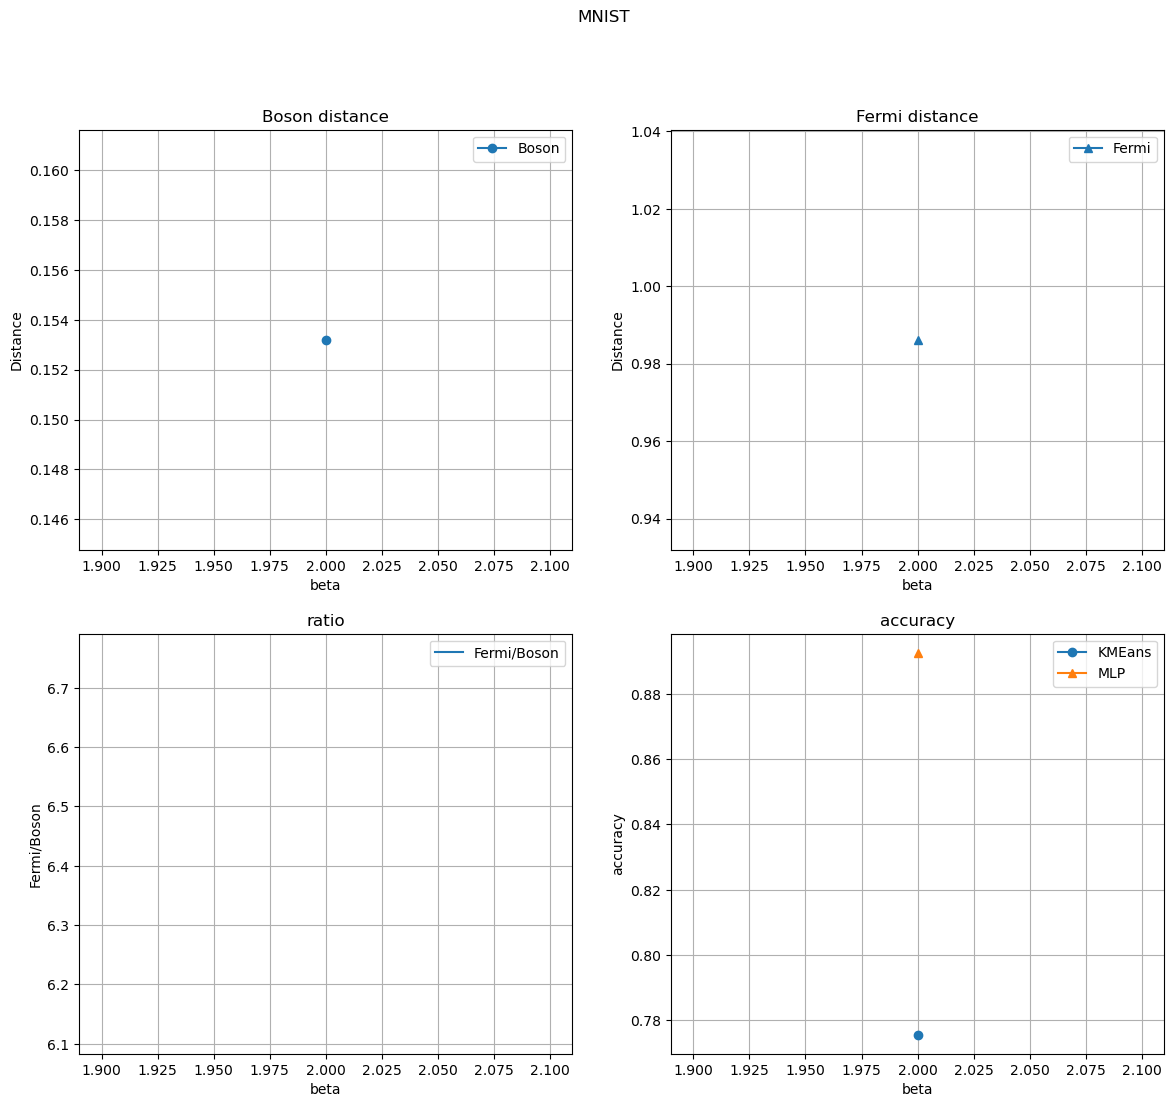

In [18]:
input_size = images_size
#Boson_list, Fermi_list, FerBos_list = [], [], []
#accuracy_list = []

beta_list = [2.0]
#layer_train(train_loader, test_loader, beta, input_size)


fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 创建一个包含3行4列子图的图像

axes[0,0].plot(beta_list, Boson_list[maxindex], label='Boson', marker='o')  # 绘制第一条曲线
axes[0,0].set_xlabel('beta')
axes[0,0].set_ylabel('Distance')
axes[0,0].set_title('Boson distance')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(beta_list, Fermi_list[maxindex], label='Fermi', marker='^')  # 绘制第二条曲线
axes[0,1].set_xlabel('beta')
axes[0,1].set_ylabel('Distance')
axes[0,1].set_title('Fermi distance')
axes[0,1].legend()
axes[0,1].grid(True)

axes[1,0].plot(beta_list, FerBos[maxindex], label='Fermi/Boson')  # 绘制第三条曲线
axes[1,0].set_xlabel('beta')
axes[1,0].set_ylabel('Fermi/Boson')
axes[1,0].set_title('ratio')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(beta_list, cluster_accuracy_list[maxindex], label='KMEans', marker='o')  # 绘制第一条曲线
axes[1,1].plot(beta_list, MLP_accuracy_list[maxindex], label='MLP', marker='^')  # 绘制第二条曲线
axes[1,1].set_xlabel('beta')
axes[1,1].set_ylabel('accuracy')
axes[1,1].set_title('accuracy')
axes[1,1].legend()
axes[1,1].grid(True)

plt.suptitle(datatype)
#plt.savefig(os.path.join(local_path, datatype+name+"_fig.png"))
#plt.close()

# Save data using pickle
save_data = {
    "Boson_list": Boson_list,
    "Fermi_list": Fermi_list,
    "accuracy_list": accuracy_list
}